Лабораторная работа № 4: **Классификация** <br>
Выполнил: **Стадников Александр, гр.6135**

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, f1_score,classification_report, confusion_matrix

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# 1. Многоклассовая классификация:
- На любом датасете продемонстрировать многоклассовую классификацию с помощью ЛЮБОГО алгоритма. Оценить accuracy.
- То же самое с использованием кросс-валидации
- Поиграться с гиперпараметром, связанным со сложностью модели (в случае kNN — k_neighbours) и построить график accuracy для train set и test_set для разных значений гиперпараметра (в лекции есть пример построения подобного графика для kNN и датасета cancer, но можно строить как угодно такой график)
- Построить confusion matrix (это вроде матрицы TN / TP/ FN/ FP, только расширенной для многоклассовой классификации, чтобы понять в какие стороны чаще ошибается классификатор). (пример):

## Описание данных

**Исходные данные:** https://www.kaggle.com/deepu1109/star-dataset <br><br>
**Набор данных: "Космические звёзды"**<br>
Этот датасет содержит характеристики звёзд. <br><br>
Цель создания набора данных - доказать, что звезды следуют определенному графику в небесном пространстве, специально называемая диаграммой Герцшпрунга-Рассела или просто HR-диаграммой так что мы можем классифицировать звезды, нанося их характеристики на основе этого графика. <br>

Набор данных, состоящий из нескольких характеристик звезд. 
Некоторые из них: 
- Абсолютная температура (в К) 
- Относительная яркость (L / Lo)
- Относительный радиус (R / Ro) 
- Абсолютная величина (Mv) 
- Цвет звезды (белый, красный, синий, желтый, желто-оранжевый и т. Д.) - Спектральный класс (O, B, A, F, G, K ,, M) 
- Тип звезды **(красный карлик, коричневый карлик, белый карлик, основная последовательность, сверхгиганты, гипергиганты)** 



---


Lo = 3,828 x 10 ^ 26 Вт (средняя яркость Солнца) <br>
Ro = 6,9551 x 10 ^ 8 м (средний радиус Солнца)



---

- Brown Dwarf -> Star Type = 0
- Red Dwarf -> Star Type = 1
- White Dwarf-> Star Type = 2
- Main Sequence -> Star Type = 3
- Supergiant -> Star Type = 4
- Hypergiant -> Star Type = 5

In [2]:
#df = pd.read_csv('02-birth.txt', sep='\s+', skiprows=[13], header=13) # sep='\s+' - один и более пробелов
stars_data = pd.read_csv(r'Stars.csv')
print(stars_data.head(10))
print('shape: ', stars_data.shape)

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0
5         2840  0.000650  0.1100  16.98   Red              M     0
6         2637  0.000730  0.1270  17.22   Red              M     0
7         2600  0.000400  0.0960  17.40   Red              M     0
8         2650  0.000690  0.1100  17.45   Red              M     0
9         2700  0.000180  0.1300  16.05   Red              M     0
shape:  (240, 7)


## Классификация (Decision tree)

#### Балансировка целевой переменной (тип звезды):

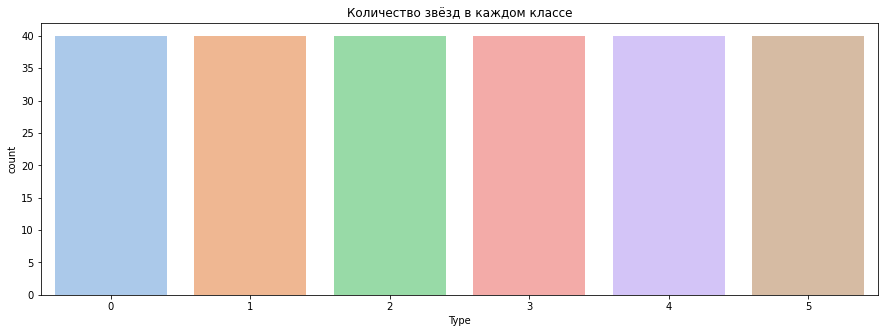

In [3]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(stars_data['Type'], palette='pastel')
ax.set(title='Количество звёзд в каждом классе')
plt.show()

--------
> **Вывод:** целевая переменная хорошо сбалансирована

#### Посмотрим корреляцию между признаками:

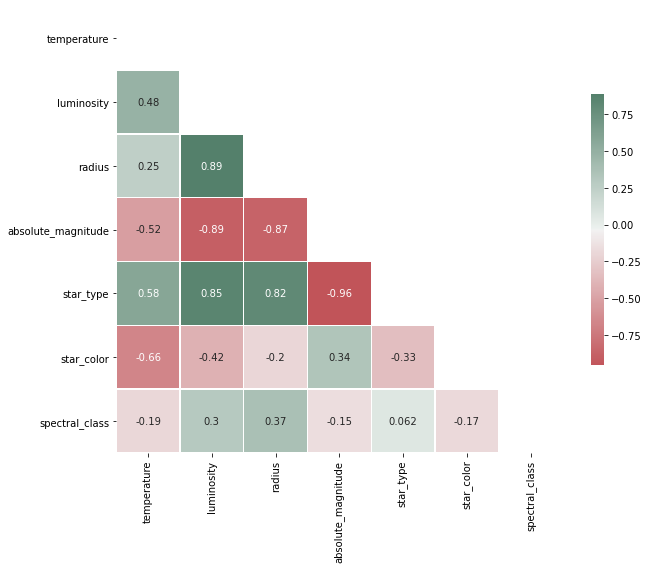

In [4]:
stars_features = {
    'temperature': stars_data['Temperature'],
    'luminosity': stars_data['L'],
    'radius': stars_data['R'],
    'absolute_magnitude': stars_data['A_M'],
    'star_type': stars_data['Type'],
    'star_color': stars_data['Color'],
    'spectral_class': stars_data['Spectral_Class']
}

stars_features = pd.DataFrame.from_dict(stars_features)
stars_features['star_type'] = stars_features['star_type'].astype('category').cat.codes
stars_features['star_color'] = stars_features['star_color'].astype('category').cat.codes
stars_features['spectral_class'] = stars_features['spectral_class'].astype('category').cat.codes

corr = stars_features.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 150, 50, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True)
plt.show()

-------
> **Вывод:** целевая переменная хорошо коррелирует с признаками luminosuty, radius, absolute_magnitude

#### Параметры для дерева решений

In [5]:
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )

#### Поиск лучших гиперпараметров

In [6]:
def do_grid_search(model,params, x_train, y_train, x_test, refit='accuracy'):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
    grid_search = GridSearchCV(model, params, scoring=['accuracy'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)

#### Вывод результата

In [7]:
def print_result(y_test, pred=None):
  print("результат классификации: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  cmap = sns.diverging_palette(220, 10, 50, as_cmap=True)
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)
  plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(stars_features.drop('star_type',axis=1), stars_features['star_type'], test_size=0.6, random_state=42)

### Без настройки гиперпараметров

результат классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        24
           4       0.91      1.00      0.95        20
           5       1.00      0.92      0.96        24

    accuracy                           0.99       144
   macro avg       0.98      0.99      0.98       144
weighted avg       0.99      0.99      0.99       144

Матрица ошибок: 
 [[26  0  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 25  0  0  0]
 [ 0  0  0 24  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  2 22]] 



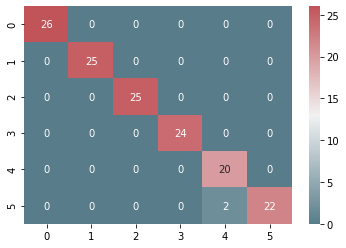

Средняя точность без настройки гиперпараметров:  0.9789473684210526


In [9]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print_result(y_test=y_test, pred=predictions)
score = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность без настройки гиперпараметров: ', np.mean(score))

------
> **Вывод:** точность довольно высокая, следовательно настройка гиперпараметров вряд ли даст значительное улучшение.

### Настройка гиперпараметров

In [10]:
do_grid_search(model=dtree,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 3852 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 14092 tasks      | elapsed:   17.9s


Best params for accuracy
{'max_depth': 4.0, 'min_samples_leaf': 0.01, 'min_samples_split': 0.01}


[Parallel(n_jobs=4)]: Done 16000 out of 16000 | elapsed:   19.5s finished


результат классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        24
           4       0.91      1.00      0.95        20
           5       1.00      0.92      0.96        24

    accuracy                           0.99       144
   macro avg       0.98      0.99      0.98       144
weighted avg       0.99      0.99      0.99       144

Матрица ошибок: 
 [[26  0  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 25  0  0  0]
 [ 0  0  0 24  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  2 22]] 



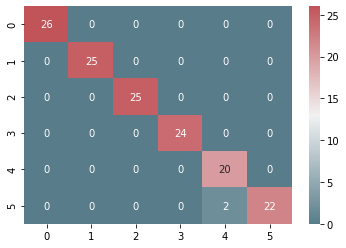

Средняя точность с настройкой гиперпараметров GridSearch:  0.9789473684210526


In [11]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=4.0, min_samples_leaf=0.01, min_samples_split=0.01)

print_result(y_test=y_test, pred=dtree_grid.fit(X_train, y_train).predict(X_test))
score = cross_val_score(dtree_grid, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))

In [12]:
max_depth = np.linspace(1, 32, 32, endpoint=True)
accuracy_result = []
cv_result = []
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

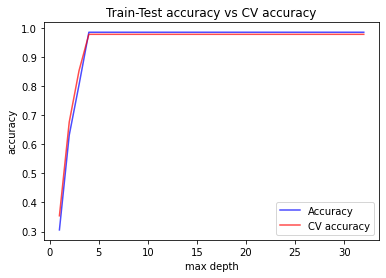

In [13]:
plt.plot(max_depth, accuracy_result, color='b', label='Accuracy', alpha=0.7)
plt.plot(max_depth, cv_result, color='r', label='CV accuracy', alpha=0.7)
plt.title('Train-Test accuracy vs CV accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

------
> **Вывод:** рост точности происходит до глубины 4, далее точность константна.

In [14]:
accuracy_result_train, accuracy_result_test = [],[]
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

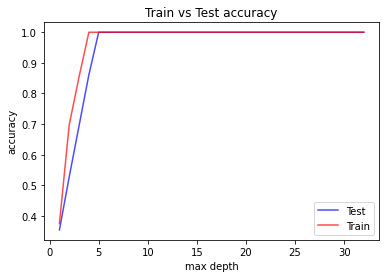

In [15]:
plt.plot(max_depth, accuracy_result_test, color='b', label='Test', alpha=0.7)
plt.plot(max_depth, accuracy_result_train, color='r', label='Train', alpha=0.7)
plt.title('Train vs Test accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

------
> **Вывод:** такой же результат дала настройка гиперпараметров поиском по сетке. <br> ***Следовательно, значение max_depth выдаёт максимальную точность 4.***

### Масштабирование признаков

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        24
           4       0.91      1.00      0.95        20
           5       1.00      0.92      0.96        24

    accuracy                           0.99       144
   macro avg       0.98      0.99      0.98       144
weighted avg       0.99      0.99      0.99       144

Матрица ошибок: 
 [[26  0  0  0  0  0]
 [ 0 25  0  0  0  0]
 [ 0  0 25  0  0  0]
 [ 0  0  0 24  0  0]
 [ 0  0  0  0 20  0]
 [ 0  0  0  0  2 22]] 



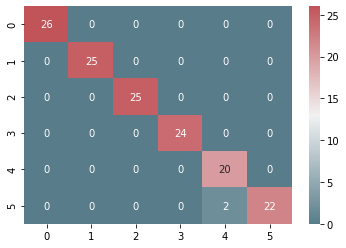

Средняя точность с масштабируемыми признаками:  0.9789473684210526


In [17]:
dtree_scaled = DecisionTreeClassifier(random_state=42)

print_result(y_test=y_test, pred=dtree_scaled.fit(X_train_scaled, y_train).predict(X_test_scaled))
score = cross_val_score(dtree_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
print('Средняя точность с масштабируемыми признаками: ', np.mean(score))

_________
_________
# Бинарная классификация
_____
___

## Описание данных

**Исходные данные:** https://www.kaggle.com/nareshbhat/wine-quality-binary-classification <br><br>
**Набор данных: классификация качества вина** <br>
Этот набор данных содержит информацию, касающуюся красного вина, различных факторов, влияющих на качество.

Входные переменные (на основе физико-химических тестов): 
-  фиксированная кислотность 
-  летучая кислотность 
-  лимонная кислота 
-  остаточный сахар 
-  хлориды 
-  свободный диоксид серы 
-  диоксид серы общий 
-  плотность 
-  pH 
-  сульфаты 
-  алкоголь 

Выходная переменная (на основе сенсорных данных): 
-  качество («хорошо» и «плохо» по баллам> 5 и <5)

In [18]:
wine_data = pd.read_csv('wine.csv')
wine_data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,bad
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,bad
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,good
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,good
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,bad


-----------
## Классификация (Логистическая регрессия)
---------

In [19]:
wine_data = wine_data.replace(['good', 'bad'], [0,1])
target = wine_data.quality
features = wine_data.drop(['quality'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

### Без настройки гиперпараметров

результат классификации: 
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       267
           1       0.68      0.73      0.70       213

    accuracy                           0.73       480
   macro avg       0.72      0.73      0.72       480
weighted avg       0.73      0.72      0.73       480

Матрица ошибок: 
 [[193  74]
 [ 58 155]] 



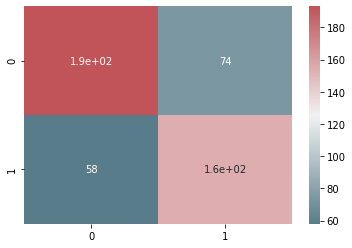

In [21]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train ,y_train)
lr_pred = lr.predict(X_test)

print_result(y_test=y_test, pred=lr_pred)

In [22]:
scores = cross_val_score(lr, X_train, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7560898462524023


### С настройкой

In [23]:
penalties = ['l2', 'none']
accuracy_result = []
cv_result = []
for penalty in penalties:
  # для 'newton-cg' возможно испльзование только 'l2' или 'none' в качестве параметров
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

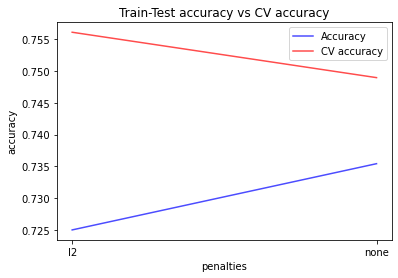

In [24]:
plt.plot(penalties, accuracy_result, color='b', label='Accuracy', alpha=0.7)
plt.plot(penalties, cv_result, color='r', label='CV accuracy', alpha=0.7)
plt.title('Train-Test accuracy vs CV accuracy')
plt.legend()
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.show()

-------
> **Вывод:** Точность по оценке train-test без регуляризации (штрафа) даёт лучший результат, но если использовать в качестве оценки алгоритма кросс-валидацию, то с использованием L2-регуляризации точность алгоритма имеет максимальное значение.

In [25]:
accuracy_result_train, accuracy_result_test = [],[]
for penalty in penalties:
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

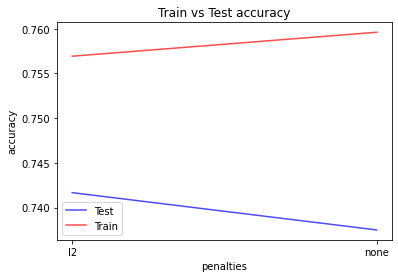

In [26]:
plt.plot(penalties, accuracy_result_test, color='b', label='Test', alpha=0.7)
plt.plot(penalties, accuracy_result_train, color='r', label='Train', alpha=0.7)
plt.title('Train vs Test accuracy')
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.legend()
plt.show()

### Масштабирование признаков

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       0.78      0.73      0.76       267
           1       0.69      0.74      0.71       213

    accuracy                           0.74       480
   macro avg       0.73      0.74      0.73       480
weighted avg       0.74      0.74      0.74       480

Матрица ошибок: 
 [[196  71]
 [ 56 157]] 



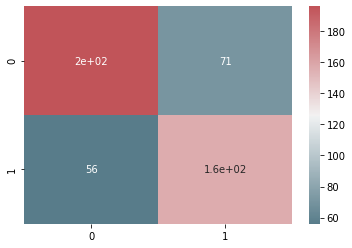

In [28]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train_scaled ,y_train)
lr_pred = lr.predict(X_test_scaled)

print_result(y_test=y_test, pred=lr_pred)

In [29]:
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  0.7498478539397821


-------
> **Вывод:** С использованием масштабирования признаков точность алгоритма уменьшилась.

### Настройка гиперпараметров

In [30]:
params={"C":[*np.arange(0,1,0.01)], "penalty":["none","l2"]}
do_grid_search(model=lr,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   37.9s finished


Best params for accuracy
{'C': 0.86, 'penalty': 'l2'}


результат классификации: 
               precision    recall  f1-score   support

           0       0.75      0.72      0.73       267
           1       0.66      0.69      0.68       213

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480

Матрица ошибок: 
 [[192  75]
 [ 65 148]] 



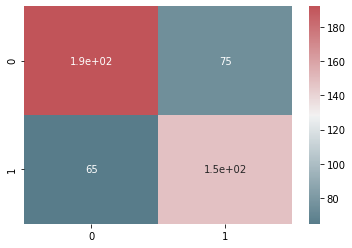

Средняя точность с настройкой гиперпараметров GridSearch:  0.7587604099935938


In [31]:
lr = LogisticRegression(C=.34,penalty="l2")
lr.fit(X_train,y_train)

print_result(y_test=y_test, pred=lr.fit(X_train, y_train).predict(X_test))
score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))

------
> **Вывод:** С настройкой гиперпараметров точность алгоритма увеличались на ~0.002